In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:

def construct_model():
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

In [5]:

model = construct_model()
batch_size = 128
epochs = 5
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

w1 = model.get_weights()

model = construct_model()
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

w2 = model.get_weights()

Epoch 1/5
422/422 [==============================] - 15s 35ms/step - loss: 0.3754 - accuracy: 0.8864 - val_loss: 0.0862 - val_accuracy: 0.9787
Epoch 2/5
422/422 [==============================] - 15s 35ms/step - loss: 0.1129 - accuracy: 0.9670 - val_loss: 0.0572 - val_accuracy: 0.9848
Epoch 3/5
422/422 [==============================] - 15s 35ms/step - loss: 0.0836 - accuracy: 0.9746 - val_loss: 0.0450 - val_accuracy: 0.9880
Epoch 4/5
422/422 [==============================] - 14s 34ms/step - loss: 0.0705 - accuracy: 0.9782 - val_loss: 0.0446 - val_accuracy: 0.9880
Epoch 5/5
422/422 [==============================] - 14s 34ms/step - loss: 0.0616 - accuracy: 0.9807 - val_loss: 0.0379 - val_accuracy: 0.9897
Epoch 1/5
422/422 [==============================] - 15s 35ms/step - loss: 0.3613 - accuracy: 0.8906 - val_loss: 0.0786 - val_accuracy: 0.9800
Epoch 2/5
422/422 [==============================] - 15s 35ms/step - loss: 0.1077 - accuracy: 0.9668 - val_loss: 0.0554 - val_accuracy: 0.9843

In [6]:
def evaluate_weights(w):
    model = construct_model()
    model.set_weights(w)
    return model.evaluate(x_test, y_test)
    

In [7]:
evaluate_weights(w1)

313/313 [==============================] - 1s 2ms/step - loss: 0.0351 - accuracy: 0.9886


[0.035120781511068344, 0.9886000156402588]

In [10]:
def line_segmentation(w1, w2, t):
    
    return [w1_*t + w2_*(1-t) for w1_, w2_ in zip(w1,w2)]

In [39]:
def path_results(wp):
    results = []
    for w in wp:
        results += [evaluate_weights(w)]
    return np.array(results)

In [40]:
ts = np.linspace(0,1,11)
wp = [line_segmentation(w1, w2, t) for t in ts]




results_lineseg = path_results(wp)

313/313 [==============================] - 1s 2ms/step - loss: 0.0351 - accuracy: 0.9886


In [45]:
from matplotlib import pylab as plt

def plot_path_results(ts, results):
    f, ax = plt.subplots(1, 2, figsize=(24,12))

    ax[0].plot(ts,results[:,0])
    ax[0].plot([0,1], [0,0], c='black', ls='--')
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('loss')
    
    ax[1].plot(ts,results[:,1])
    ax[1].plot([0,1], [1,1], c='black', ls='--')
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('accuracy')

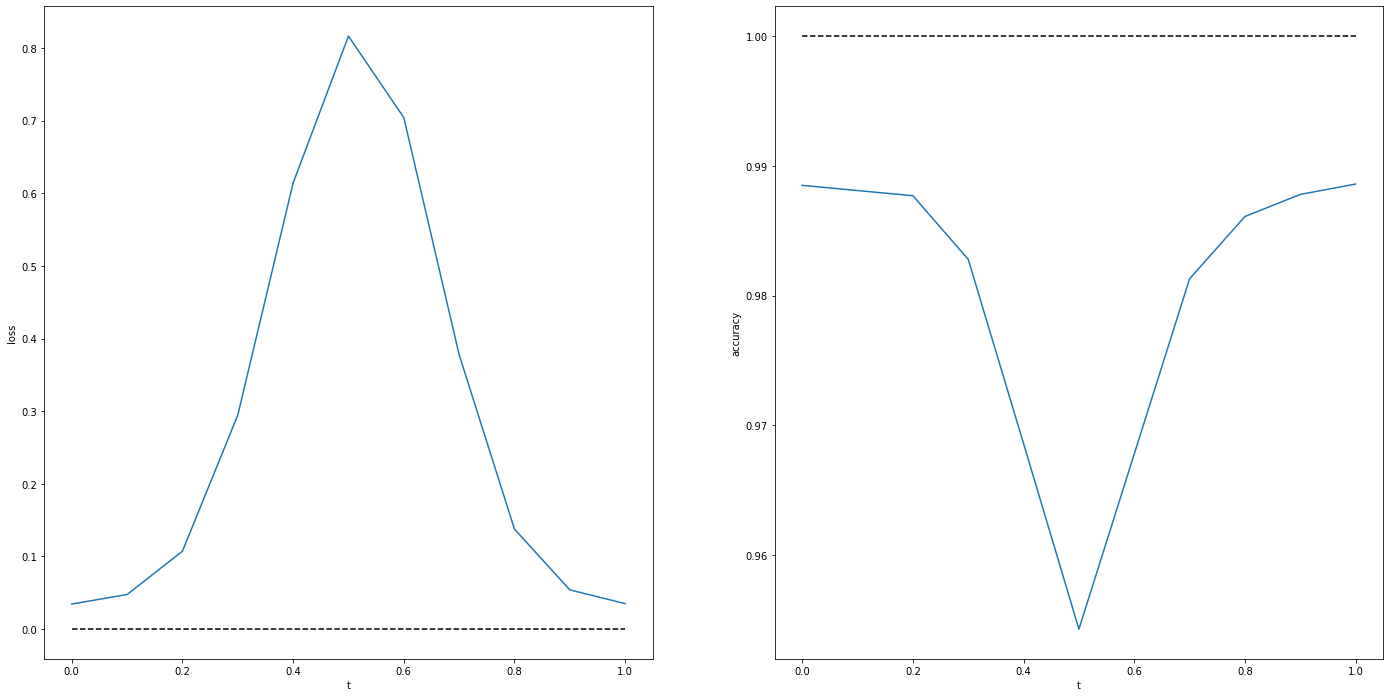

In [46]:
plot_path_results(ts, results_lineseg)

In [47]:
def polygonal_chain(w1,w2, wt,t_samples):
    
    ws = []# sampled weights from t_samples given the polygonal chain parametrization (w1, w2, wt)
    for t in t_samples:
        if t<0.5:
            ws += [[2*(t*wt_ + (0.5 - t)*w1_) for w1_,wt_ in zip(w1, wt)]]
        else:
            ws += [[2*((t-0.5)*w2_ + (1-t)*wt_) for w2_,wt_ in zip(w2, wt)]]
    return ws
            
    

## Sample a valid simple polynomial chain paramater wd ($\theta$ in the paper)
wd must be inside the hyperbox $minimum(w1_i,w2_i) \leq wd_i \leq maximum(w1_i,w2_i)$ for $i=1,..,N$,
where N is the number of parameters in the ANN model and w_i is parameter indexed i in the same space.

In [48]:

wmin = [np.minimum(w1_,w2_) for w1_, w2_ in zip(w1, w2)]
wd = [abs(w1_ - w2_) for w1_, w2_ in zip(w1, w2)]

w0 = [wmin_ + wd_*np.random.rand() for wmin_, wd_ in zip(wmin, wd)] # sample an initial value for wt(theta)


In [53]:
t_samples = np.linspace(0,1,11)#np.random.rand(4)
ws = polygonal_chain(w1=w1,w2=w2, wt=w0,t_samples=t_samples)

In [51]:

results_random_pc = path_results(ws)

313/313 [==============================] - 1s 2ms/step - loss: 0.0346 - accuracy: 0.9885


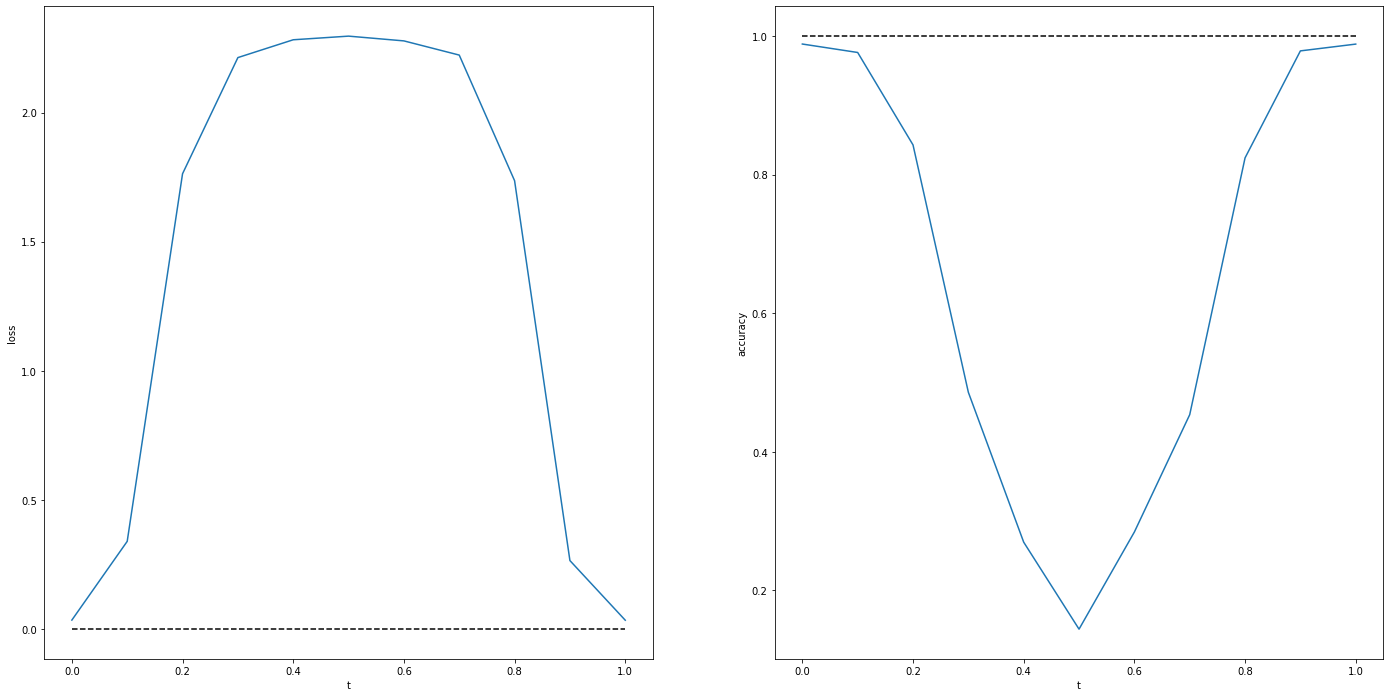

In [52]:
plot_path_results(ts, results_random_pc)

In [60]:
loss_func = tf.keras.losses.CategoricalCrossentropy()
loss_func.in

AttributeError: 'CategoricalCrossentropy' object has no attribute 'input'

In [61]:
import tensorflow as tf
outputTensor = model.output
listOfVariableTensors = model.trainable_weights
#bce = keras.losses.BinaryCrossentropy()
loss_func = tf.keras.losses.CategoricalCrossentropy()
loss = loss_func#(outputTensor, labels)
gradients = tf.keras.gradients(loss, listOfVariableTensors)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
training_data1 = (x_train[:100], y_train[:100])
evaluated_gradients = sess.run(gradients,feed_dict={model.input:training_data1})
print(evaluated_gradients)

AttributeError: module 'tensorflow.keras' has no attribute 'gradients'

In [73]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  # Forward pass
  y = layer(x)
  loss = tf.reduce_mean(y**2)

# Calculate gradients with respect to every trainable variable
print("loss: ", loss)
grad = tape.gradient(loss, layer.trainable_variables)
print("grad: ", grad)

loss:  tf.Tensor(0.7756885, shape=(), dtype=float32)
grad:  [<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.40023088, 1.1794882 ],
       [0.80046177, 2.3589764 ],
       [1.2006927 , 3.5384645 ]], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.40023088, 1.1794882 ], dtype=float32)>]


In [76]:
ss = range(10)
with tf.GradientTape() as tape:
  # Forward pass
    y_pred = model(x_train[ss])
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    sample_loss = loss_fn(y_train[ss],y_pred)#.numpy()
    print(sample_loss.shape)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(sample_loss, model.trainable_variables)
print("grad: ", grad)

gradient = []

()
grad:  [<tf.Tensor: shape=(3, 3, 1, 32), dtype=float32, numpy=
array([[[[ 1.9866819e-04, -5.5701373e-04, -3.0841111e-04,
           1.7473256e-04,  2.7949293e-04,  1.9457815e-03,
          -2.3758116e-03,  9.1439049e-04, -7.3864736e-04,
          -4.4883287e-04, -1.4578807e-03,  5.9713610e-04,
           5.1247381e-04,  7.5352797e-04, -2.0991045e-03,
           2.8266804e-06,  3.7550618e-04, -1.9465875e-03,
           1.7799932e-04, -2.9835070e-04, -6.3051528e-04,
          -1.1000466e-03, -1.2916347e-03, -6.8522402e-04,
          -2.9706192e-05,  6.2088267e-04,  1.1164586e-03,
          -1.3526463e-03, -3.9088758e-04,  2.0720335e-04,
          -1.8702750e-03,  2.2286622e-04]],

        [[ 8.1719307e-04, -7.5154298e-04, -3.7859689e-04,
          -6.3770707e-04,  2.6805291e-04,  2.6125726e-03,
          -2.6613926e-03,  5.3447986e-04, -2.1663083e-04,
          -1.0499187e-03, -1.8312454e-03,  2.0507064e-04,
           1.1288689e-03,  9.4226573e-04, -1.7429015e-03,
          -6.122867

In [69]:
ss
x_train[ss]

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 